# Goal
DISEASE PROBABILITY PREDICTION FROM CHEST X RAY IMAGES

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

NumPy is a library for numerical computing in Python, and is often used for working with arrays and matrices of numerical data.

Pandas is a library for data manipulation and analysis, and is often used for working with structured data in tabular form.

Matplotlib is a library for data visualization, and is often used for creating plots and charts to display data.

The os library is also imported, which provides a way to interact with the file system in Python.

Finally, the glob library is imported, which provides a way to find files using pattern matching.

The %matplotlib inline command is a special command used in Jupyter Notebooks to display plots and charts directly in the notebook output.

The import matplotlib.pyplot as plt command imports the pyplot module from Matplotlib, which is used for creating various types of charts and plots.

In [2]:
all_xray_df = pd.read_csv('../input/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input','data', 'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x))
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
17052,00004572_000.png,No Finding,0,4572,38,M,PA,2500,2048,0.171,0.171,NaN,../input/data/images_003/images/00004572_000.png
73321,00018044_028.png,No Finding,28,18044,34,F,PA,2582,2991,0.143,0.143,NaN,../input/data/images_008/images/00018044_028.png
52391,00013229_003.png,Infiltration,3,13229,35,M,AP,2500,2048,0.168,0.168,NaN,../input/data/images_006/images/00013229_003.png


* The code reads in a CSV file called "Data_Entry_2017.csv" located in a folder called "data" using the Pandas read_csv() function.
* The CSV file contains metadata for a set of chest X-ray images, including information such as patient age, gender, and whether the image contains evidence of disease.
* The code also uses the glob() function from the glob library to find all PNG image files in a folder called "images" located in the parent directory of the current directory.
* The code creates a dictionary of image file names and their corresponding file paths using the os.path.basename() and glob() functions.
* The code then adds a new column to the Pandas DataFrame called "path" by mapping the image file names to their corresponding file paths using the map() method.
* The code also converts the "Patient Age" column in the DataFrame from a string to an integer using the map() method and a lambda function.

Finally, the code samples three rows at random from the DataFrame using the sample() method and prints them to the console.

# Preprocessing 

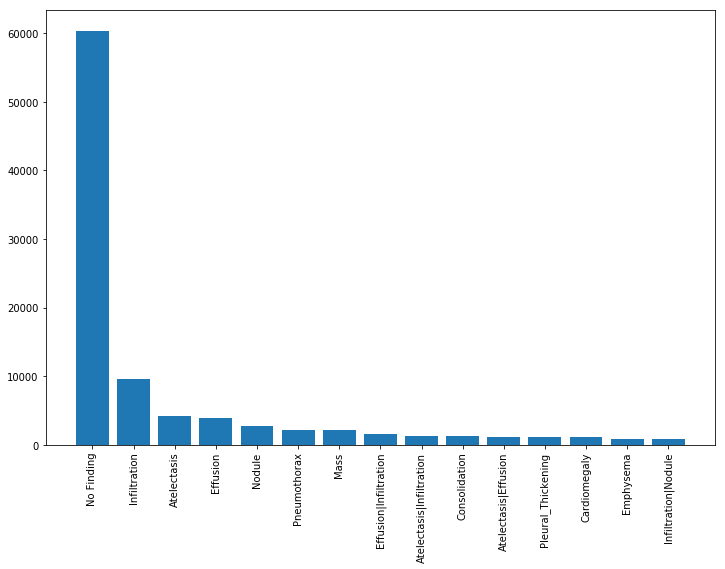

In [3]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

* The code creates a new variable called label_counts that counts the number of occurrences of each unique value in the "Finding Labels" column of the Pandas DataFrame called all_xray_df.
* The code limits the count to the top 15 most frequently occurring values using Python slicing syntax ([:15]).
* The code then creates a new figure using the subplots() function from the matplotlib.pyplot library, with one row and one column, and a figure size of 12 by 8 inches.
* The code creates a bar chart on the figure using the bar() function, with the x-values set to a numpy array ranging from 0.5 to the number of labels plus 0.5 (to center the bars over their corresponding labels) and the y-values set to the counts from label_counts.
* The code sets the x-tick locations to the center of each bar using the set_xticks() method and the same numpy array used for the x-values, and then sets the x-tick labels to the index values of label_counts (which are the unique values in the "Finding Labels" column) using the set_xticklabels() method.
* Finally, the code suppresses the output of the set_xticklabels() method using an underscore (_) and sets the rotation of the x-tick labels to 90 degrees using the rotation parameter of the set_xticklabels() method.

In [4]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
29800,00007747_003.png,,3,7747,32,F,PA,2048,2500,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
107033,00028876_037.png,Atelectasis|Pneumothorax,37,28876,41,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
42088,00010828_031.png,Atelectasis|Consolidation,31,10828,45,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* all_xray_df['Finding Labels'] is a Pandas series containing the labels of each x-ray image
* The code replaces the label 'No Finding' with an empty string
* from itertools import chain is importing the chain function from the itertools module
* all_labels is a numpy array containing all unique labels present in the dataset, created by splitting the labels in all_xray_df['Finding Labels'] and then flattening the list of lists
* Labels with length 0 are filtered out
* For each label in all_labels, a new column is added to all_xray_df with the same name as the label and filled with 1.0 if the label is present in all_xray_df['Finding Labels'], otherwise filled with 0.0
* The last line prints 3 randomly sampled rows from the modified all_xray_df dataframe

### Clean categories


In [5]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

Clean Labels (13) [('Atelectasis', 11559), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13317), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Pleural_Thickening', 3385), ('Pneumonia', 1431), ('Pneumothorax', 5302)]


* The code sets a minimum number of cases to keep at 1000.
* It creates a new list of labels called "all_labels" by removing any empty labels and checking the number of cases for each label using the "sum()" function.
* It filters the "all_labels" list by only keeping labels that have more than 1000 cases using a "for" loop and the "sum()" function again.
* It prints out the number of clean labels and the corresponding number of cases for each label.

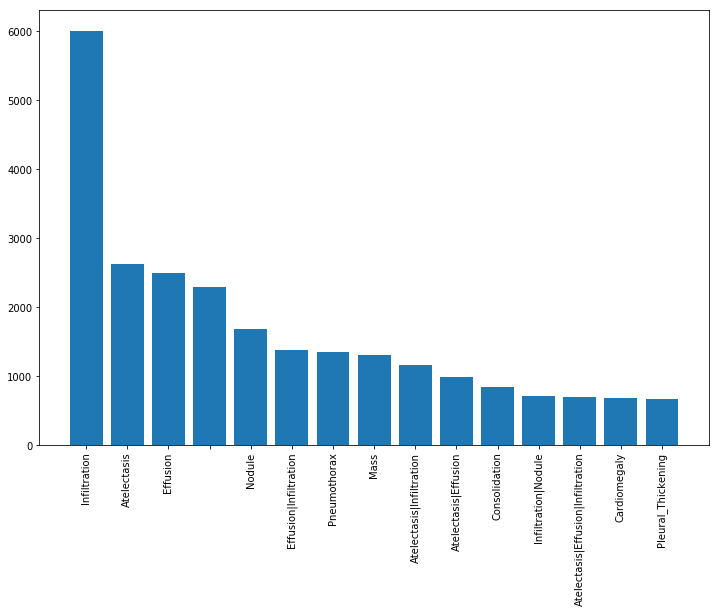

In [6]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
all_xray_df = all_xray_df.sample(40000, weights=sample_weights)

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

* The code calculates sample weights for each row in the dataframe based on the number of findings in the 'Finding Labels' column. The weight is calculated as 0.1 plus the number of findings, divided by the sum of all weights.
* The code then samples 40,000 rows from the dataframe with replacement, using the calculated sample weights as the probability of selecting each row.
* The resulting dataframe is plotted to show the top 15 most common findings, using a bar chart with the 'Finding Labels' column as the x-axis and the frequency count as the y-axis.

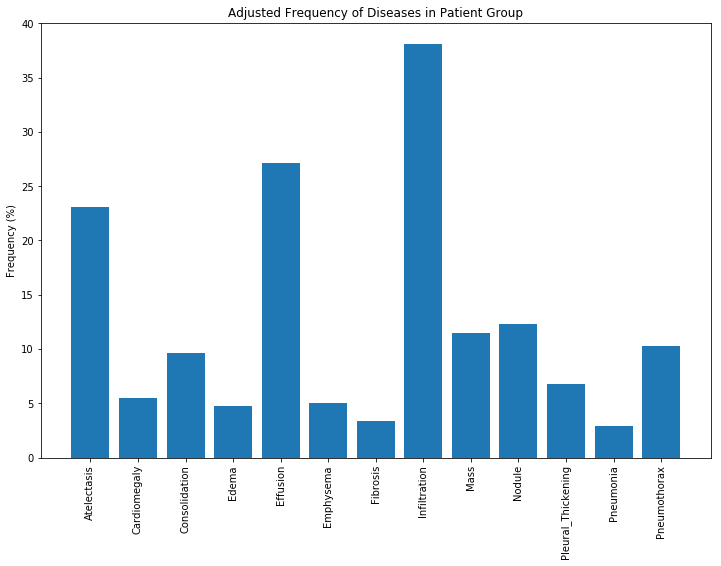

In [7]:
label_counts = 100*np.mean(all_xray_df[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

* label_counts = 100*np.mean(all_xray_df[all_labels].values,0) computes the frequency of each disease in the patient group by taking the mean of the binary disease labels (1 if the disease is present, 0 if not) for each disease label.
* fig, ax1 = plt.subplots(1,1,figsize = (12, 8)) creates a new figure object and returns a tuple with the figure object and a single axis object.
* ax1.bar(np.arange(len(label_counts))+0.5, label_counts) creates a bar plot of the disease frequency, where np.arange(len(label_counts))+0.5 provides the x-axis values for each bar, and label_counts provides the height of each bar.
* ax1.set_xticks(np.arange(len(label_counts))+0.5) sets the x-axis tick positions to be in the center of each bar.
* ax1.set_xticklabels(all_labels, rotation = 90) sets the labels for each x-axis tick to be the disease label names, rotated 90 degrees.
* ax1.set_title('Adjusted Frequency of Diseases in Patient Group') sets the title of the plot.
* _ = ax1.set_ylabel('Frequency (%)') sets the y-axis label to "Frequency (%)".

+0.5 is added to shift the bars of the bar plot by half a unit to the right. This is done to center the bars on their corresponding x-tick labels, which are placed at integer positions on the x-axis. By default, the left edge of the first bar is aligned with the 0 tick label, which would make the bars appear off-center. Adding +0.5 shifts the bars to the right by half a unit, aligning their centers with the tick labels.

# Prepare Training Data


In [8]:
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

* all_xray_df is a pandas DataFrame containing information about chest X-ray images, including the presence or absence of various diseases.
* The apply method is called on all_xray_df to apply a function to each row of the DataFrame.
* The lambda function passed to apply takes a row (x) and returns a list of the values of the diseases for that row, extracted using x[all_labels].values.
* The map method is called on the resulting DataFrame of lists to extract the first element of each list, returning a DataFrame with a single column of disease vectors.
* The new disease vector column is assigned to all_xray_df['disease_vec'].

In [9]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_xray_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 30000 validation 10000


* The train_test_split function from the sklearn.model_selection module is imported.
* The all_xray_df DataFrame is split into training and validation sets using train_test_split.
* The test_size parameter is set to 0.25, which means that 25% of the data will be used for validation and 75% for training.
* The random_state parameter is set to 2018, which means that the random number generator will produce the same sequence of numbers each time the code is run.
* The stratify parameter is set to all_xray_df['Finding Labels'].map(lambda x: x[:4]), which means that the data will be split in a way that preserves the proportion of cases for each of the top four diseases (as determined by the first four characters in the Finding Labels column).
* The sizes of the resulting training and validation sets are printed to the console.

# Create Data Generators
Data generators are a way to load and preprocess data in batches, particularly useful for large datasets that cannot be loaded entirely into memory at once. Instead, data generators load data in batches, typically from disk or over a network, and process it on-the-fly before passing it to a model for training or inference.

In the context of deep learning, data generators are commonly used with the fit_generator() method in Keras, which allows for training a model with data that is too large to fit into memory all at once. The fit_generator() method takes as input a generator object that generates batches of data for each training step.

A data generator typically contains a loop that continually loads and preprocesses data in batches, returning each batch as an input to the model. Data generators can also perform data augmentation, such as random rotations or flips, to increase the diversity of the training data and prevent overfitting.

In [10]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


* from keras.preprocessing.image import ImageDataGenerator imports the ImageDataGenerator class from the keras.preprocessing.image module.
* IMG_SIZE = (128, 128) sets the image size to 128 by 128 pixels.
* core_idg = ImageDataGenerator(...) creates an instance of the ImageDataGenerator class with various image augmentation settings specified by the arguments passed to it. The settings are as follows:
* samplewise_center=True centers the image data at 0 by subtracting the mean pixel value of the whole dataset from each pixel.
* samplewise_std_normalization=True normalizes the image data to have unit variance.
* horizontal_flip=True randomly flips images horizontally.
* vertical_flip=False does not flip images vertically.
* height_shift_range=0.05 randomly shifts the height of the image by up to 5% of the image height.
* width_shift_range=0.1 randomly shifts the width of the image by up to 10% of the image width.
* rotation_range=5 randomly rotates the image by up to 5 degrees.
* shear_range=0.1 randomly applies shear transformation to the image.
* fill_mode='reflect' fills any newly created pixels due to augmentation by reflecting the image across its edges.
* zoom_range=0.15 randomly zooms in/out of the image by up to 15%.

In [11]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

 defines a function named flow_from_dataframe that takes the following arguments:

* img_data_gen: an instance of ImageDataGenerator class from Keras that performs data augmentation on images
* in_df: a Pandas DataFrame that contains information about images and their labels
* path_col: a string that specifies the name of the column in in_df containing file paths of the images
* y_col: a string that specifies the name of the column in in_df containing labels for the images
* **dflow_args: additional arguments to be passed to ImageDataGenerator.flow_from_directory method

The function performs the following steps:

* Extract the directory name from the first file path in path_col column of in_df
* Create an instance of ImageDataGenerator.flow_from_directory method with the base_dir and class_mode arguments and any additional arguments passed to flow_from_dataframe as **dflow_args
* Replace the filenames and classes attributes of the df_gen object created in step 2 with values from path_col and y_col columns of in_df, respectively
* Set the samples, n, and _index_array attributes of df_gen to the number of rows in in_df
* Set the directory attribute of df_gen to an empty string since we have the full path to images in path_col
* Return df_gen, which is an instance of ImageDataGenerator.flow_from_directory method with replaced attributes and additional attributes from **dflow_args

In [12]:
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 32)

valid_gen = flow_from_dataframe(core_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 256) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_X, test_Y = next(flow_from_dataframe(core_idg, 
                               valid_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 1024)) # one big batch

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 30000 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 10000 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 10000 images


* The code is generating train, validation and test data generators for the model. Here's what each line is doing:

* train_gen = flow_from_dataframe(core_idg, train_df, path_col='path', y_col='disease_vec', target_size=IMG_SIZE, color_mode='grayscale', batch_size=32) : This line is creating a training data generator using the flow_from_dataframe() function. It takes in the core_idg ImageDataGenerator, the train_df dataframe, the path column name path_col, the label column name y_col, and other arguments such as target size, color mode, and batch size.

* valid_gen = flow_from_dataframe(core_idg, valid_df, path_col='path', y_col='disease_vec', target_size=IMG_SIZE, color_mode='grayscale', batch_size=256) : This line is creating a validation data generator using the flow_from_dataframe() function. It takes in the same arguments as the training generator, except for the valid_df dataframe.

* test_X, test_Y = next(flow_from_dataframe(core_idg, valid_df, path_col='path', y_col='disease_vec', target_size=IMG_SIZE, color_mode='grayscale', batch_size=1024)) : This line is creating a test dataset by taking the first batch of the validation data generator using the next() function. It returns the batch of images and labels as test_X and test_Y, respectively.

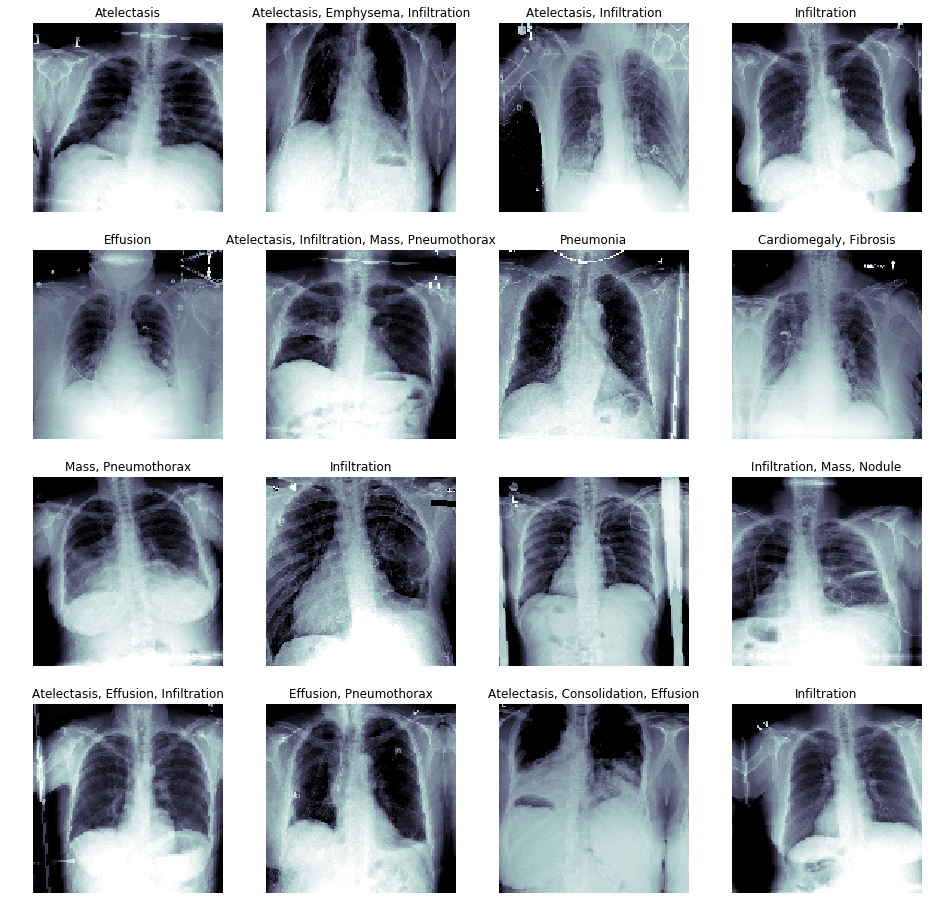

In [13]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

* t_x, t_y = next(train_gen): loads a batch of training data with the next function applied to the train_gen object.

* fig, m_axs = plt.subplots(4, 4, figsize = (16, 16)): creates a figure with 4 rows and 4 columns, containing subplots to show 16 images.

* for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()): loops through each image and its corresponding label in the loaded batch and its corresponding axis to plot.

* c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5): displays the image as a grayscale image with the 'bone' colormap and sets the minimum and maximum pixel values to -1.5 and 1.5, respectively.

* c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) if n_score>0.5])): sets the title of the subplot with the labels that have a score higher than 0.5. The join function concatenates the labels in the list returned by the list comprehension, separated by a comma.

* c_ax.axis('off'): removes the axis labels from the subplot.

# The Model

In [14]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
base_mobilenet_model = MobileNet(input_shape =  t_x.shape[1:], 
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228288   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 13)                6669      
Total params: 3,759,757
Trainable params: 3,737,869
Non-trainable params: 21,888
_____________________________________________________________

* Import the MobileNet architecture from Keras and some layers from Keras as well.
* Create a base model using the MobileNet architecture with input shape same as the shape of t_x (output of train_gen).
* include_top is set to False which means that the last layer of the MobileNet model is excluded, so we can add our own layers on top.
* weights is set to None so that the model is randomly initialized instead of using pre-trained weights.
* Create a new sequential model called multi_disease_model.
* Add the base_mobilenet_model to the multi_disease_model.
* Add a GlobalAveragePooling2D layer to the multi_disease_model.
* Add a Dropout layer with 50% dropout rate to the multi_disease_model.
* Add a fully connected Dense layer with 512 units to the multi_disease_model.
* Add another Dropout layer with 50% dropout rate to the multi_disease_model.
* Add another fully connected Dense layer with len(all_labels) units, which is the number of output classes, and an activation function of sigmoid.
* Compile the multi_disease_model using the adam optimizer and binary_crossentropy loss function for binary classification tasks.
* Metrics used for evaluation include binary_accuracy and mae (mean absolute error).
* Print the summary of the multi_disease_model.

**MobileNet** is a convolutional neural network architecture that was designed specifically for mobile and embedded devices with low computational power and memory. The main idea behind MobileNet is to use depth-wise separable convolutions instead of traditional convolutions to reduce the number of parameters and the computational cost of the model while maintaining its accuracy

In Keras, Sequential is a model class that allows us to create models layer by layer in a sequential manner. It is the simplest type of model in Keras and is appropriate for most problems

GlobalAveragePooling2D() layer is added to the model to reduce the spatial dimensions of the output of the MobileNet model, resulting in a fixed-size output which is then fed to the fully connected layers.

Dropout is a regularization technique used in neural networks to prevent overfitting. It randomly drops out (sets to zero) a fraction of the input units during training, which helps to prevent over-reliance on particular input units and encourages the model to learn more robust features.

In the code, Dropout(0.5) is added twice after the global average pooling and the first dense layer, respectively, with a dropout rate of 0.5 (i.e., 50%). This means that during training, 50% of the neurons in those layers will be randomly set to 0, which helps to reduce overfitting.

In the context of the given code, Dense refers to a fully connected layer. A dense layer connects all the neurons from the previous layer to the current layer.

In the code, Dense is used to add two fully connected layers to the model, one with 512 units and another with the number of units equal to the number of labels in the dataset. The activation function for the final dense layer is sigmoid, which makes sense for a binary classification problem where each label can be either present or absent in the image.

In [15]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

* ModelCheckpoint is a callback function in Keras that saves the model weights at certain intervals during training.
* weight_path is a string that is used to name the saved weights file.
* monitor='val_loss' specifies the metric to monitor, which in this case is the validation loss.
* verbose=1 specifies the level of verbosity. In this case, it is set to 1 which means that progress messages will be displayed on the console.
* save_best_only=True means that only the weights that result in the best performance on the validation set will be saved.
* mode='min' specifies whether the monitored metric should be minimized or maximized. In this case, the monitored metric is the validation loss, which should be minimized.
* save_weights_only=True means that only the weights of the model will be saved, and not the full model.
* EarlyStopping is another Keras callback function that stops the training process if the monitored metric stops improving.
* patience=3 specifies the number of epochs with no improvement after which training will be stopped. In this case, training will be stopped if the validation loss does not improve for 3 epochs.
* callbacks_list is a list that contains the ModelCheckpoint and EarlyStopping callbacks. These callbacks will be passed to the fit method of the model to be used during training.

# First Round
Here we do a first round of training 

In [16]:
multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch=100,
                                  validation_data = (test_X, test_Y), 
                                  epochs = 1, 
                                  callbacks = callbacks_list)

Epoch 1/1
 99/100 [============================>.] - ETA: 4s - loss: 0.4570 - binary_accuracy: 0.8527 - mean_absolute_error: 0.2003
Epoch 00001: val_loss improved from inf to 0.57132, saving model to xray_class_weights.best.hdf5
100/100 [==============================] - 512s 5s/step - loss: 0.4565 - binary_accuracy: 0.8527 - mean_absolute_error: 0.2005 - val_loss: 0.5713 - val_binary_accuracy: 0.8727 - val_mean_absolute_error: 0.1564


* multi_disease_model.fit_generator: This function fits the model on data generated batch-by-batch by a Python generator.

* train_gen: It is the generator that generates the training data.

* steps_per_epoch: It is the number of batches of samples to use in one epoch.

* validation_data: It is the data on which to evaluate the loss and any model metrics at the end of each epoch. Here, test_X and test_Y are the validation data.

* epochs: It is the number of epochs to train the model. An epoch is an iteration over the entire training dataset.

* callbacks: It is a list of callback functions that are applied at certain points during training. Here, the list contains checkpoint and early callbacks.

* checkpoint: It saves the weights of the best performing model during training.
* early: It stops the training process if the validation loss stops improving after a certain number of epochs.

# Check Output
Here we see how many positive examples we have of each category

In [17]:
for c_label, s_count in zip(all_labels, 100*np.mean(test_Y,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

Atelectasis: 24.02%
Cardiomegaly: 5.66%
Consolidation: 9.08%
Edema: 4.98%
Effusion: 28.91%
Emphysema: 5.37%
Fibrosis: 4.00%
Infiltration: 37.50%
Mass: 12.40%
Nodule: 12.40%
Pleural_Thickening: 7.03%
Pneumonia: 2.54%
Pneumothorax: 11.62%


* For each class label c_label and corresponding score s_count in the zip object of all_labels and 100 times the mean of test_Y along the 0th axis (column-wise mean), respectively:
* Print the string '%s: %2.2f%%', where %s is replaced with the current c_label and %2.2f%% is replaced with the current s_count formatted as a percentage with two decimal places.
* The output of this snippet is a printout of the percentage of each class label present in the test_Y array.

* s_count is calculated using np.mean(test_Y,0).

* test_Y is a binary matrix where each row represents an image and each column represents a label. If a label is present for an image, its corresponding column value will be 1, otherwise 0. np.mean(test_Y,0) calculates the mean of each column (label) across all images, resulting in an array of size (num_labels,) where each value represents the proportion of images in the test set that have that particular label.

* Multiplying this array by 100 gives the percentage of images in the test set that have each label.

In [18]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

1024/1024 [==============================] - 42s 41ms/step


* pred_Y is a variable that stores the predicted outputs of the multi_disease_model for the given input test_X.
* multi_disease_model.predict() is a method in Keras that is used to predict the outputs for a given input.
* The method takes the following parameters:
* test_X: the input data for which the predictions are to be made.
* batch_size: the number of samples to be processed at once. In this case, 32 samples will be processed at a time.
* verbose: controls the verbosity of the output during prediction. In this case, it is set to True to show the progress bar during prediction.
* After running this code, pred_Y will contain the predicted outputs of the model for the given input data.

# ROC Curves
While a very oversimplified metric, we can show the ROC curve for each metric

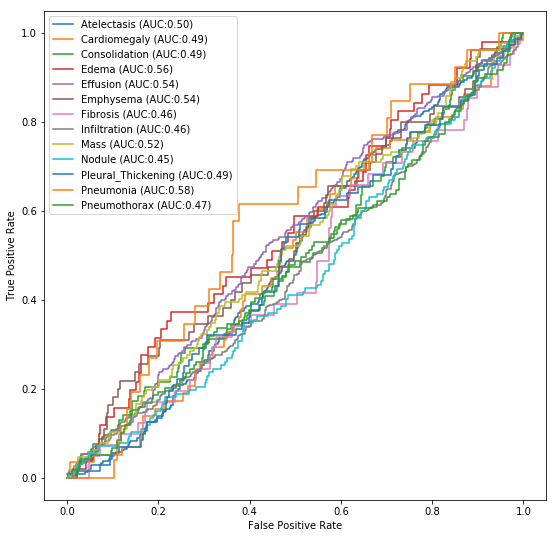

In [19]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

* Import the necessary libraries roc_curve and auc from the sklearn.metrics module.
* Create a new figure fig with one subplot c_ax with a size of 9x9 using plt.subplots().
* Iterate through all the labels in all_labels list along with its index using enumerate():
* Compute the ROC curve and AUC score using roc_curve() and auc() functions.
* Plot the ROC curve with False Positive Rate as x-axis and True Positive Rate as y-axis using plot() method of c_ax.
* Set the label for the curve with the class name and AUC score using label parameter of plot().
* Add the legend to the plot with legend() method of c_ax.
* Set the x-axis label to 'False Positive Rate' and y-axis label to 'True Positive Rate' using set_xlabel() and set_ylabel() methods of c_ax.
* Save the plot as an image named 'barely_trained_net.png' using savefig() method of fig.

# Continued Training
Now we do a much longer training process to see how the results improve

In [20]:
history = multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch = 100,
                                  validation_data =  (test_X, test_Y), 
                                  epochs = 7, 
                                  callbacks = callbacks_list)

Epoch 1/7
 99/100 [============================>.] - ETA: 4s - loss: 0.3876 - binary_accuracy: 0.8668 - mean_absolute_error: 0.1967
Epoch 00001: val_loss improved from 0.57132 to 0.36294, saving model to xray_class_weights.best.hdf5
100/100 [==============================] - 504s 5s/step - loss: 0.3871 - binary_accuracy: 0.8669 - mean_absolute_error: 0.1966 - val_loss: 0.3629 - val_binary_accuracy: 0.8707 - val_mean_absolute_error: 0.1962
Epoch 2/7
 99/100 [============================>.] - ETA: 4s - loss: 0.3495 - binary_accuracy: 0.8717 - mean_absolute_error: 0.1964
Epoch 00002: val_loss did not improve
100/100 [==============================] - 500s 5s/step - loss: 0.3494 - binary_accuracy: 0.8718 - mean_absolute_error: 0.1963 - val_loss: 0.3714 - val_binary_accuracy: 0.8641 - val_mean_absolute_error: 0.1709
Epoch 3/7
 99/100 [============================>.] - ETA: 4s - loss: 0.3371 - binary_accuracy: 0.8739 - mean_absolute_error: 0.1942
Epoch 00003: val_loss improved from 0.36294 t

In [21]:
# load the best weights
multi_disease_model.load_weights(weight_path)

* This code loads the best weights that were saved during the training process.
* The load_weights() method is used to load the saved weights. It takes in the path to the saved weight file as an argument.
* By loading the saved weights, we can use the trained model for prediction or further training without having to retrain the model from scratch.
* In this case, the saved weights correspond to the best performing model on the validation set during training, which were saved using the ModelCheckpoint callback.


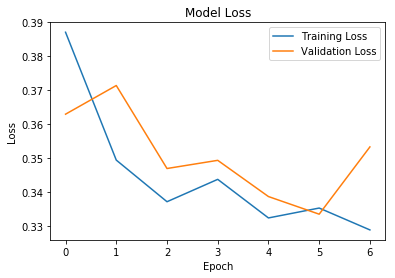

In [22]:
import matplotlib.pyplot as plt

# Plot the training and validation loss over each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()


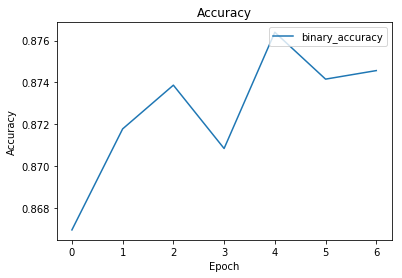

In [23]:
# Plot the training and validation loss over each epoch
plt.plot(history.history['binary_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['binary_accuracy'], loc='upper right')
plt.show()

In [24]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

1024/1024 [==============================] - 48s 47ms/step


* multi_disease_model is the name of the Keras model trained on X-ray images to classify different thoracic diseases.
* test_X is the input test data (i.e., X-ray images) to predict the output labels.
* batch_size = 32 means that the data will be divided into batches of size 32 during the prediction process.
* verbose = True means that the progress bar will be displayed during the prediction process.
* pred_Y is a numpy array containing the predicted labels for the test data.

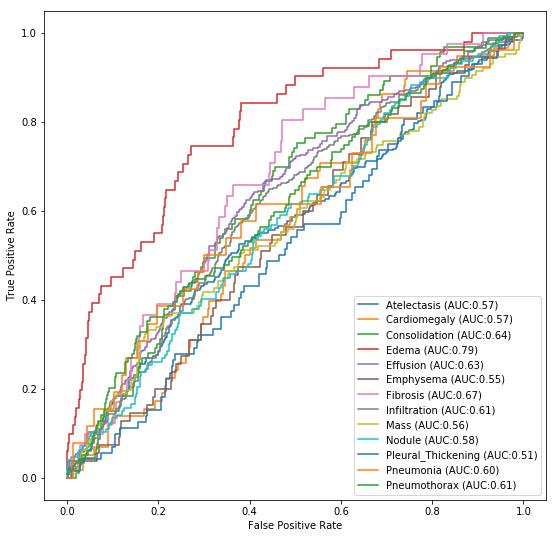

In [25]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

In [26]:
# look at how often the algorithm predicts certain diagnoses 
for c_label, p_count, t_count in zip(all_labels, 
                                     100*np.mean(pred_Y,0), 
                                     100*np.mean(test_Y,0)):
    print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))

Atelectasis: Dx: 24.02%, PDx: 23.81%
Cardiomegaly: Dx: 5.66%, PDx: 5.71%
Consolidation: Dx: 9.08%, PDx: 8.64%
Edema: Dx: 4.98%, PDx: 4.47%
Effusion: Dx: 28.91%, PDx: 35.57%
Emphysema: Dx: 5.37%, PDx: 5.50%
Fibrosis: Dx: 4.00%, PDx: 2.25%
Infiltration: Dx: 37.50%, PDx: 40.73%
Mass: Dx: 12.40%, PDx: 10.01%
Nodule: Dx: 12.40%, PDx: 11.40%
Pleural_Thickening: Dx: 7.03%, PDx: 7.04%
Pneumonia: Dx: 2.54%, PDx: 2.18%
Pneumothorax: Dx: 11.62%, PDx: 10.73%


This code block calculates and prints the following information for each label in all_labels:
 
* c_label: the name of the label being analyzed
* t_count: the percentage of images in the test set that have the label (PDx)
* p_count: the percentage of images in the test set that are predicted to have the label (Dx)
* The percentages are calculated by taking the mean of the respective arrays (test_Y and pred_Y) for the label being   analyzed and multiplying by 100.

Overall, this code block provides an assessment of how well the model is performing for each label in the test set.

# Show a few images and associated predictions

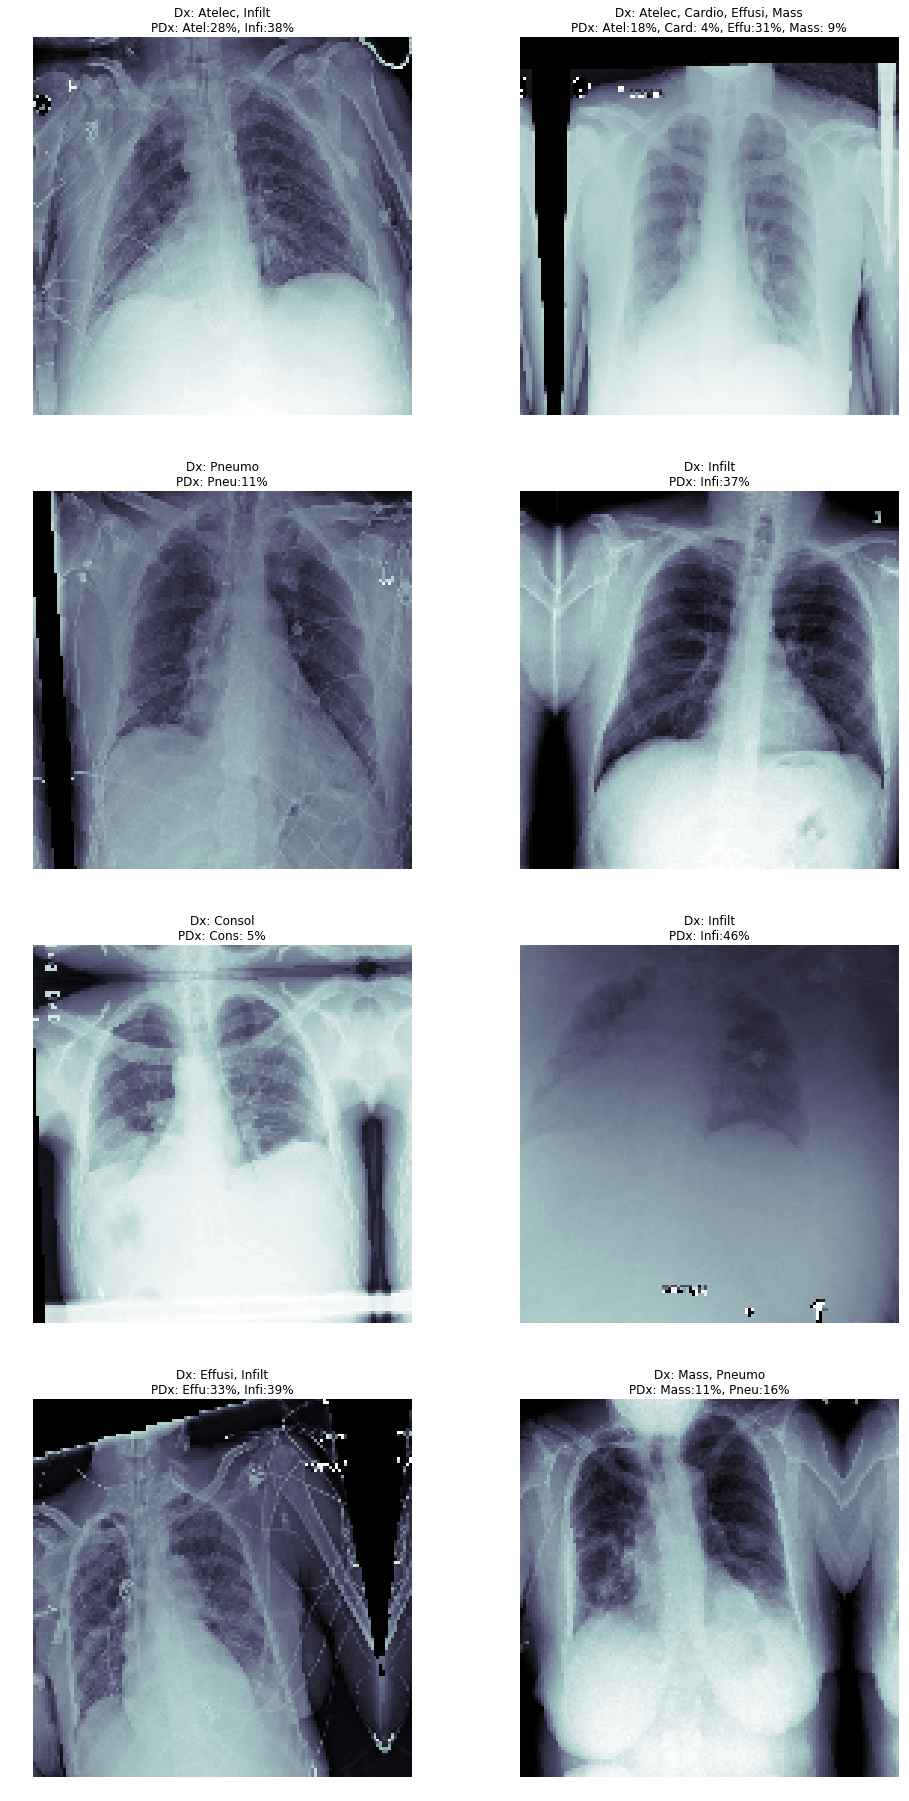

In [27]:
sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(all_labels, 
                                                                  test_Y[idx]) 
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels, 
                                                                  test_Y[idx], pred_Y[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')

* sickest_idx is an array containing the indices of patients with the least number of labels.
* fig, m_axs = plt.subplots(4, 2, figsize = (16, 32)) creates a figure with 4 rows and 2 columns of subplots (8 subplots in total), with a size of 16 inches by 32 inches.
* The for loop iterates over the indices of the patients in sickest_idx, and for each patient:
* c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone') displays the patient's X-ray image on the subplot.
* stat_str is a list of the patient's actual diagnoses, where each diagnosis is truncated to the first 6 characters.
* pred_str is a list of the patient's predicted diagnoses and their corresponding scores, where each diagnosis is truncated to the first 4 characters and the score is expressed as a percentage.
* c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str)) sets the title of the subplot with the actual and predicted diagnoses of the patient.
* c_ax.axis('off') removes the axis of the subplot.
* fig.savefig('trained_img_predictions.png') saves the figure as an image file named "trained_img_predictions.png".

In [28]:
multi_disease_model.save('my_model.h5')



In [29]:
from IPython.display import FileLink
FileLink(r'./my_model.h5')


/kaggle/working/my_model.h5